**In this notebook, I am going to build a model of 10-year AMD stock price using ARIMA model.**

In [1]:
#Import data from yfinance

!pip install yfinance

In [2]:
import pandas as pd
import yfinance as yf
import requests
import datetime
from datetime import date, timedelta

symbol = ["AMD"]
stock_data = yf.download(symbol, start=datetime.datetime(2013, 1, 1),
                                    end=datetime.datetime(2023, 12, 31), group_by='tickers')
stock_data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,2.55,2.57,2.45,2.53,2.53,27214800
2013-01-03,2.52,2.59,2.46,2.49,2.49,24966900
2013-01-04,2.51,2.59,2.49,2.59,2.59,22054200
2013-01-07,2.61,2.70,2.60,2.67,2.67,25575200
2013-01-08,2.72,2.76,2.64,2.67,2.67,29140800
2013-01-09,2.70,2.72,2.60,2.63,2.63,16675100
2013-01-10,2.69,2.70,2.61,2.62,2.62,19408800
2013-01-11,2.63,2.68,2.55,2.67,2.67,20032100
2013-01-14,2.68,2.70,2.62,2.64,2.64,17300300


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2768 non-null   float64
 1   High       2768 non-null   float64
 2   Low        2768 non-null   float64
 3   Close      2768 non-null   float64
 4   Adj Close  2768 non-null   float64
 5   Volume     2768 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.4 KB


In [4]:
# Dataframe to contain Adjusted Close Price for this company's stock
adj_close = pd.DataFrame()

adj_close = stock_data['Adj Close']

adj_close

Date
2013-01-02      2.530000
2013-01-03      2.490000
2013-01-04      2.590000
2013-01-07      2.670000
2013-01-08      2.670000
                 ...    
2023-12-22    139.600006
2023-12-26    143.410004
2023-12-27    146.070007
2023-12-28    148.759995
2023-12-29    147.410004
Name: Adj Close, Length: 2768, dtype: float64

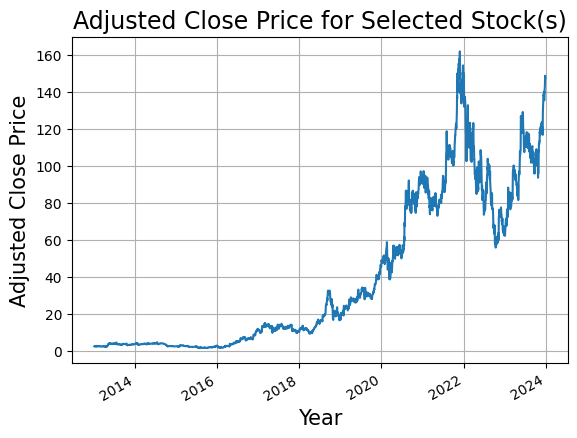

In [5]:
#plot adj_close data for the period between 2013 to 2023
import seaborn as sns
import matplotlib.pyplot as plt

adj_close.plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Adjusted Close Price for Selected Stock(s)', color = 'black', fontsize = 17)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Adjusted Close Price', color = 'black', fontsize = 15);

In [6]:
#Only stationary time series can be modelled by ARIMA, stationary means it is mean reverting. But actually most of the stock prices are not mean reverting.
#Therefore, we need to first check that if the time series of interest is stationary by using ADF (Augmented Dickey-Fuller) test
#if p<0.05, then we can infer that it is stationary. Vice versa, it is not.
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(adj_close.dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
#since the p-value is much higher than 0.05, so the adjusted close price data for AMD stock is not stationary.

ADF Statistic: 0.2107292925271101
p-value: 0.9728569874601853


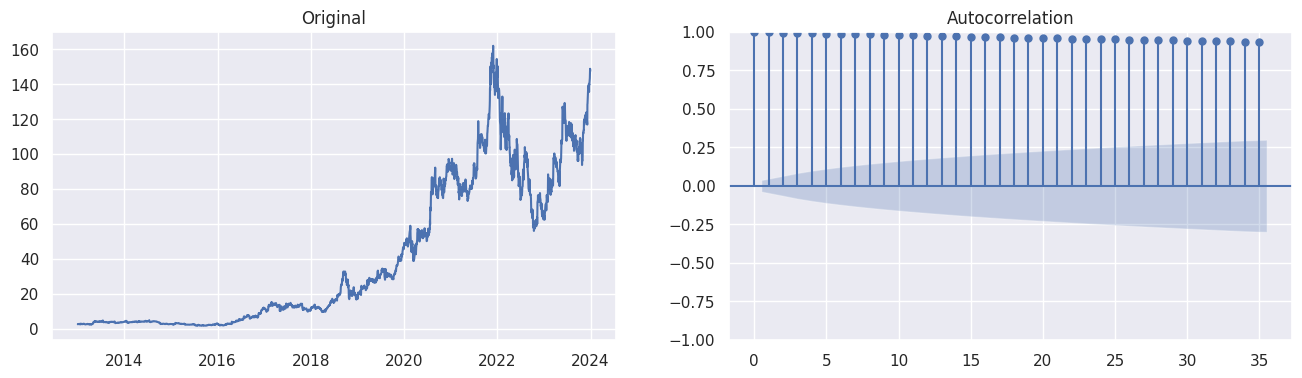

In [7]:
"""
To transfer this non-stationary adjusted closed price time series to a stationary time series, we need to difference it for d times (d is a parameter in
ARIMA model), because returns (how one day price is different from the price at the previous day) are usually stationary time series
"""
"""
To find the order of differencing (d), we can use ACF (Autocorrelation Function) plot. It is a measure of how much the values of a time series are correlated
with each other over time. the first lag is the correlation between the time series and its values from the previous time period, the second lag is the correlation
between the time series and its values from two time periods ago, and so on. If a time series has high autocorrelation, it means that the values are strongly
correlated with their lagged values, and the time series may not be stationary. In contrast, if a time series has low autocorrelation, it means that the values are
not strongly correlated with their lagged values, and the time series may be stationary.

Autocorrelation can be visualized using an autocorrelation plot, which shows the correlation coefficients for different lags.
"""
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(adj_close)
ax1.set_title("Original")
plot_acf(adj_close, ax=ax2);
#Before differecing, the correlation values are high, which indicates that this is a non-stationary time series.

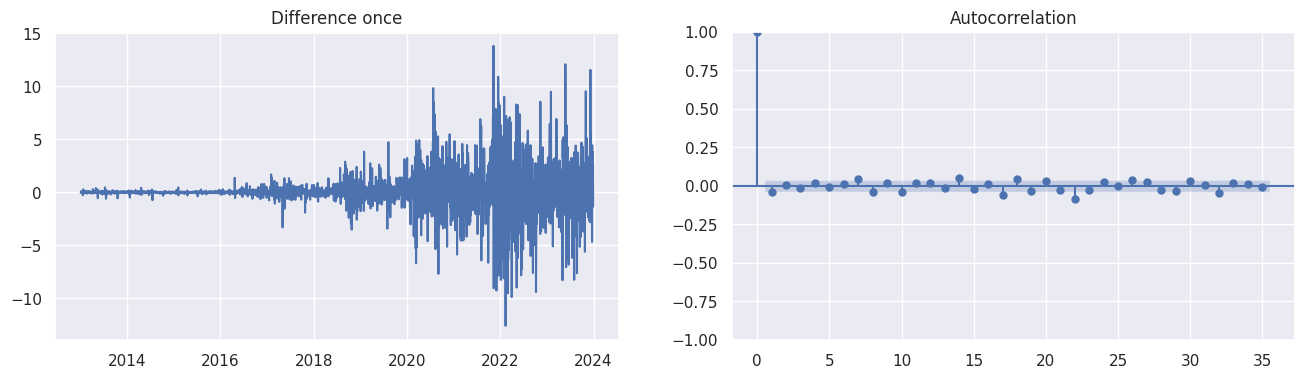

In [8]:
#Difference once
diff = adj_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);
#It can be seen that the returns randomly distribute around the mean of 0. And the autocorrelation cofficients are closed to zero.


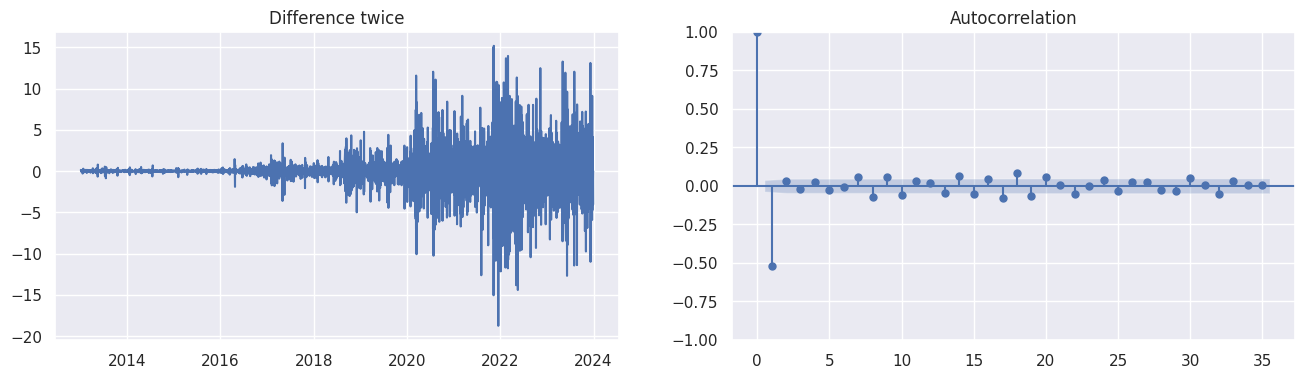

In [9]:
#Difference twice
diff2 = adj_close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff2)
ax1.set_title("Difference twice")
plot_acf(diff2, ax=ax2);

#The large negative lag in acf plot observed in the second order of differencing suggests that it may have been overdifferenced. Therefore, we will select a first order of differencing.

In [10]:
#Apart from using acf plot, we can also use a library function ndiffs to help us find the order of differencing
!pip install pmdarima
from pmdarima.arima.utils import ndiffs

print("")
print("The order of differencing should be:")
ndiffs(adj_close, test="adf")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00

The order of differencing should be:


1

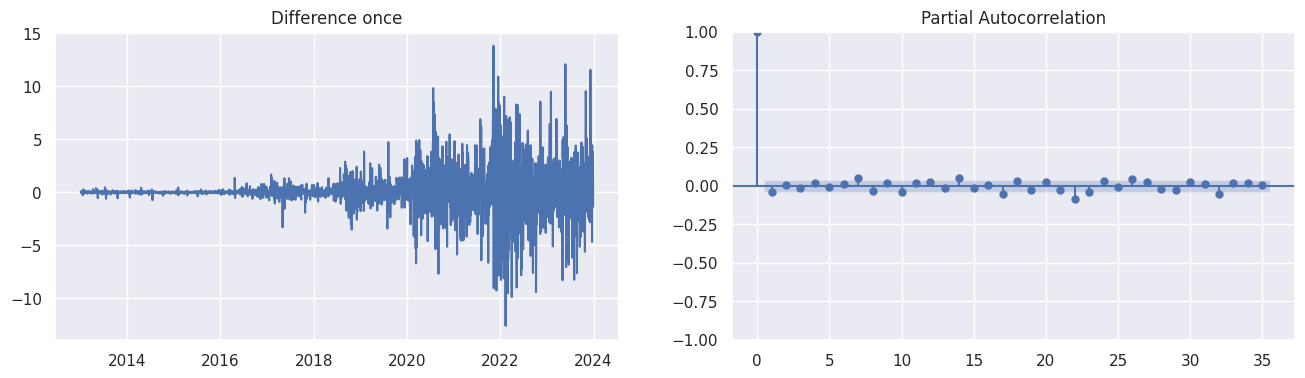

In [11]:
# To determine the p term (auto regressive (AR) term) in arima model, which is the number of lags to be used as predictors, we can inspect PACF plot (Partial Autocorrelation).
from statsmodels.graphics.tsaplots import plot_pacf

diff = adj_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_pacf(diff, ax=ax2);
#Choose p=7 (or p=1) because lag of 7 is above the significance line, and after which the PACF coefficients are not significant anymore

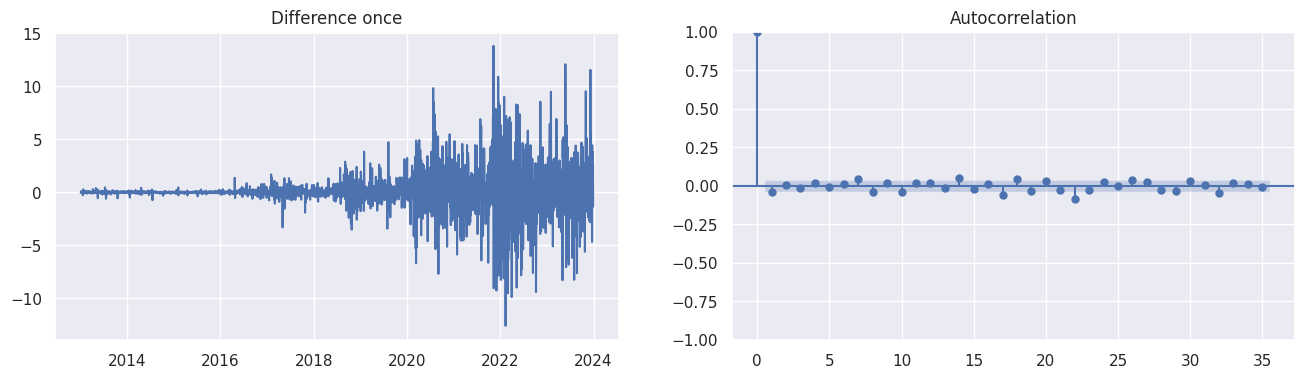

In [12]:
# To determine the q term (moving average (MA) term) in arima model, which is number of lagged forecast errors in the model. we can inspect ACF plot to find q.
diff = adj_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);
#Choose q=1 (or q = 7) because lag of 1 is above the significance line.

In [13]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(adj_close, order = (7,1,1)) # order is (p, d, q)
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2768
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -5647.407
Date:                Wed, 13 Mar 2024   AIC                          11312.813
Time:                        11:37:29   BIC                          11366.143
Sample:                             0   HQIC                         11332.075
                               - 2768                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6069      0.110     -5.515      0.000      -0.823      -0.391
ar.L2         -0.0204      0.013     -1.624      0.104      -0.045       0.004
ar.L3         -0.0091      0.011     -0.805      0.4

(array([1.34078894e-04, 1.60894672e-03, 4.69276128e-03, 1.74302562e-02,
        2.64001342e-01, 6.58327368e-02, 1.26034160e-02, 3.62013013e-03,
        8.04473362e-04, 4.02236681e-04]),
 array([-13.07710355, -10.38263266,  -7.68816177,  -4.99369087,
         -2.29921998,   0.39525091,   3.08972181,   5.7841927 ,
          8.47866359,  11.17313449,  13.86760538]),
 <BarContainer object of 10 artists>)

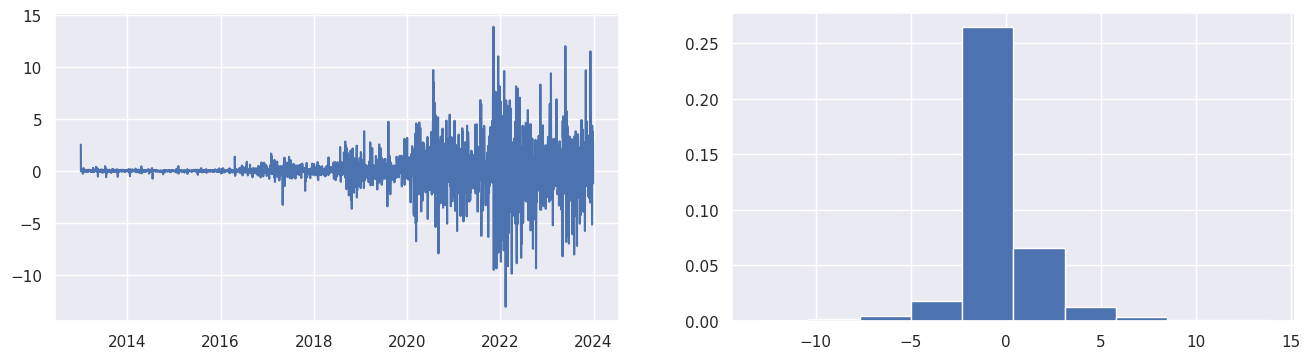

In [15]:
#Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

2768


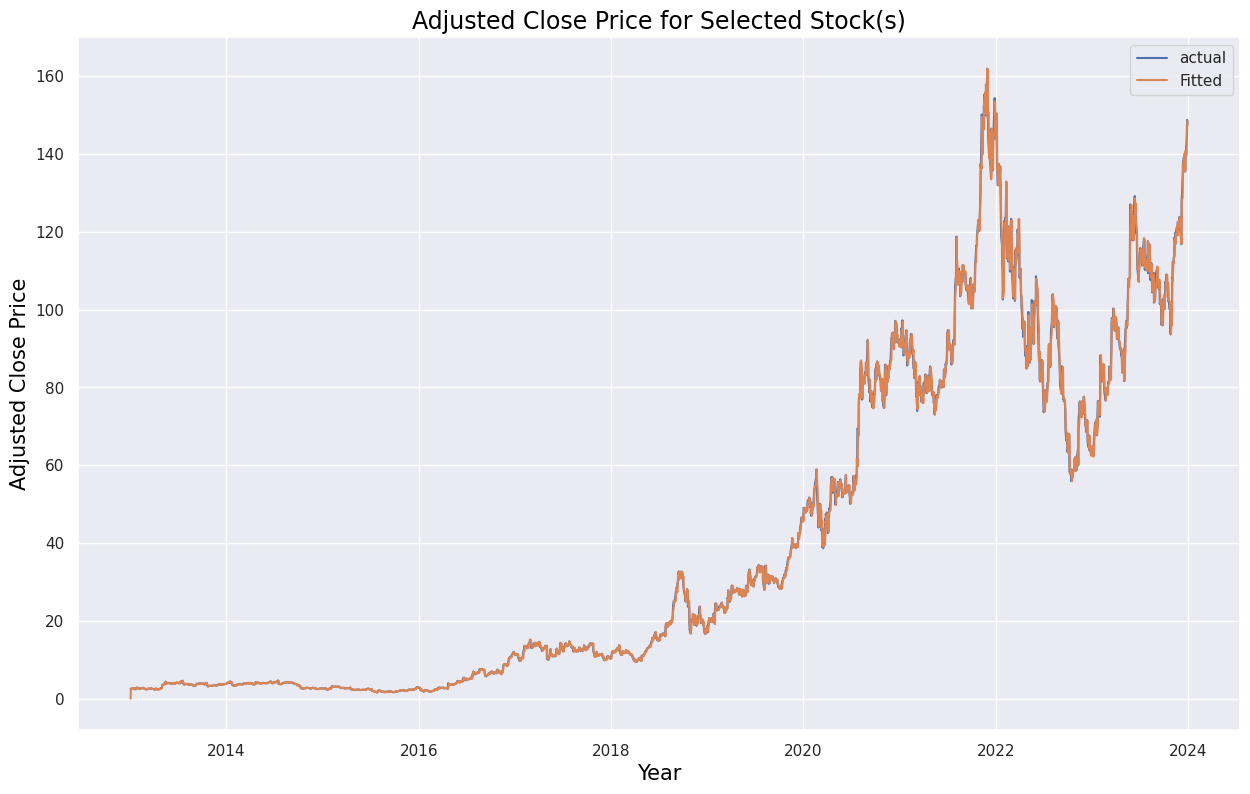

In [16]:
# Compare between Actual and Fitted
print(adj_close.size)
pred = result.predict(
    dynamic=False
)

#adj_close.plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.plot(adj_close, label='actual')
plt.plot(pred, label='Fitted')
plt.title('Adjusted Close Price for Selected Stock(s)', color = 'black', fontsize = 17)
plt.legend(['actual', 'Fitted'])
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Adjusted Close Price', color = 'black', fontsize = 15);

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2024-01-02 to 2024-03-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       48 non-null     float64
 1   High       48 non-null     float64
 2   Low        48 non-null     float64
 3   Close      48 non-null     float64
 4   Adj Close  48 non-null     float64
 5   Volume     48 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 2.6 KB


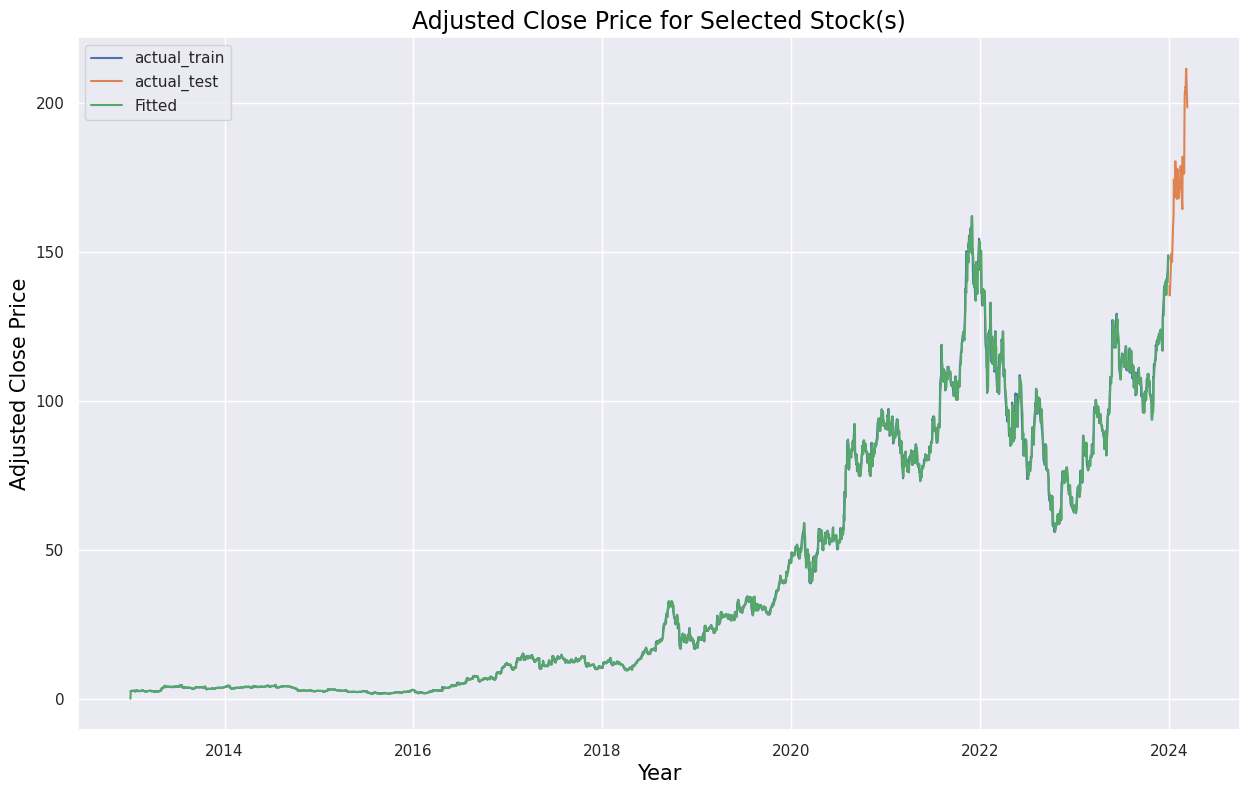

In [17]:
# Creating a test set to examine the effectivity of the model
stock_data_test = yf.download(symbol, start=datetime.datetime(2024, 1, 1),
                                    end=datetime.datetime(2024, 3, 12), group_by='tickers')
stock_data_test.info()
adj_close_test = pd.DataFrame()

adj_close_test = stock_data_test['Adj Close']

adj_close_test

sns.set(rc={'figure.figsize':(15, 9)})
plt.plot(adj_close, label='actual_train')
plt.plot(adj_close_test, label='actual_test')
plt.plot(pred, label='Fitted')
plt.title('Adjusted Close Price for Selected Stock(s)', color = 'black', fontsize = 17)
plt.legend(['actual_train', 'actual_test','Fitted'])
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Adjusted Close Price', color = 'black', fontsize = 15);

In [23]:
step = 48
fc = result.get_forecast(step)
pred_mean = fc.predicted_mean
conf = fc.conf_int(alpha=0.05)
print(type(fc))
print(pred_mean)
print(conf)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>
2768    147.266656
2769    147.657744
2770    147.486073
2771    147.831746
2772    147.810077
2773    147.973459
2774    147.785635
2775    147.895275
2776    147.853364
2777    147.872981
2778    147.880023
2779    147.877115
2780    147.886313
2781    147.870483
2782    147.886329
2783    147.874549
2784    147.882893
2785    147.878163
2786    147.881046
2787    147.879605
2788    147.879734
2789    147.880467
2790    147.879422
2791    147.880491
2792    147.879596
2793    147.880297
2794    147.879782
2795    147.880115
2796    147.879942
2797    147.879999
2798    147.880016
2799    147.879961
2800    147.880030
2801    147.879962
2802    147.880021
2803    147.879975
2804    147.880007
2805    147.879988
2806    147.879997
2807    147.879995
2808    147.879993
2809    147.879997
2810    147.879992
2811    147.879997
2812    147.879993
2813    147.879996
2814    147.879994
2815    147.879995
Name: predicted_m

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
print(type(fc))

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


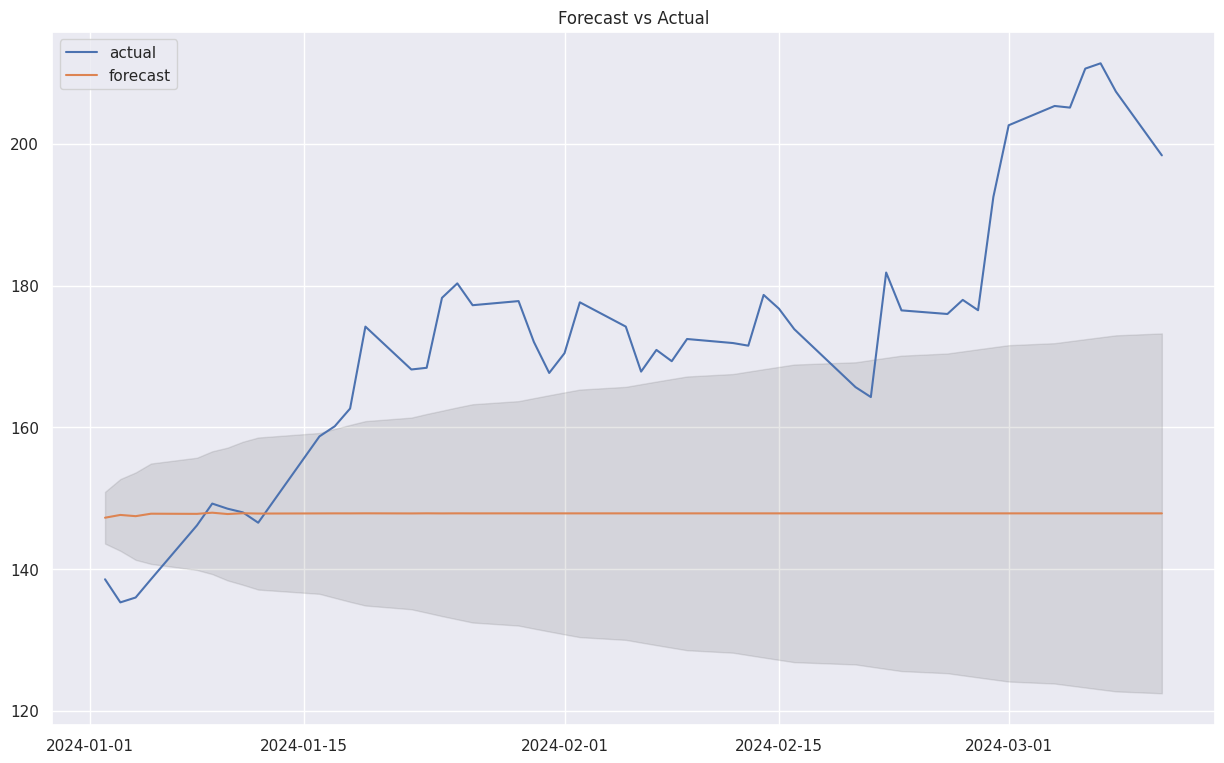

In [24]:
#print(pred_mean.type())
#pred_mean = pd.Series(pred_mean, index=adj_close_test[:step].index)
pred_mean.index = adj_close_test[:step].index
lower = conf.iloc[:, 0]
lower.index = adj_close_test[:step].index
upper = conf.iloc[:, 1]
upper.index = adj_close_test[:step].index
#lower = pd.Series(conf.iloc[:, 0], index=adj_close_test[:step].index)
#upper = pd.Series(conf.iloc[:, 1], index=adj_close_test[:step].index)
plt.figure()
plt.plot(adj_close_test[:step], label="actual")
plt.plot(pred_mean, label="forecast")
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

**Conclusion: ARIMA model does not perform well when forecasting AMD stock price. It may be cauased by low relativity between future prices and historical prices.**